# 3. Construcción del modelo RNA-backpropagation

In [ ]:
options(warm=-1)  # no mostrar mensajes de alerta

In [3]:
# Librerias necesarias para el modelo

library(neuralnet) # libreria para generar las redes neuronales
library(readxl)   # libreria para leer datos de excel

El Modelo de RNA de propagación hacia atrás (Backpropagation - BP) consiste en utilizar para el entrenamiento de la red neuronal el algoritmo de aprendizaje BP.  Según Llano et al., (Llano et al., 2007), este algoritmo fue creado como generalización del algoritmo para perceptrón continuo cuando se tienen múltiples capas o (redes neuronales perceptrón multicapa) y es popularmente utilizado para la solución de problemas de clasificación y pronóstico.

El nombre de Backpropagation, es producto de la forma en que el error es propagado hacia atrás a través de la red neuronal desde la capa de salida. “Esto permite que los pesos sobre las conexiones de las neuronas ubicadas en las capas ocultas cambien durante el entrenamiento” según Damián (Damián, 2001), este cambio en el peso de las conexiones influye en la entrada global, en la activación y consecuente en la salida de la neurona, lo que lleva a tener en cuenta las variaciones de la función de activación. Damián llama a esto sensibilidad de la función de activación. En la siguiente figura se muestra el modelo de la Red Neuronal con retropropagación (backpropagation).
 
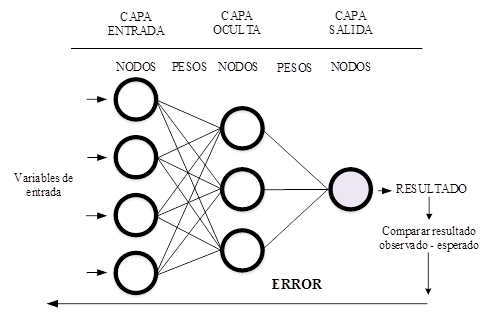

El funcionamiento de la red Backpropagation, consiste en el aprendizaje de un conjunto predefinido de pares de entradas-salidas. Valencia, Yáñez, & Sánchez (2006, p. 5) explica que primero se hace un estímulo a la primera capa mediante un patrón de entrada, y este se va propagando a través de las capas superiores hasta generar una salida, para luego comparar los resultados en las neuronas de salida con los resultados deseados y se calcula un error para cada neurona de salida, luego dichos errores se propagan hacia atrás desde la capa de salida hacia las neuronas intermedias que estén directamente relacionas con ella en la proporción que estas aportaron a esta salida. 


Para el desarrollo del modelo de Red Neuronal se utiliza la metodologia que se expone en la siguiente figura:

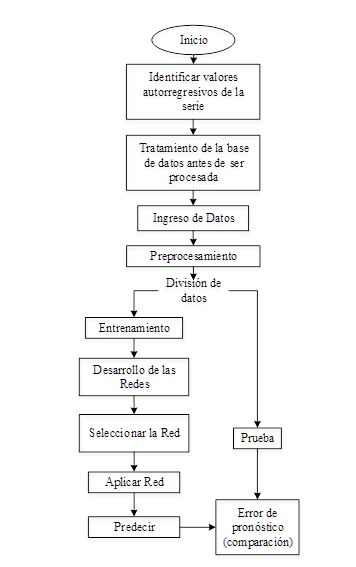

Los valores autorregresivos de la serie se identifican a traves de las graficas de autocorrelación parcial de los datos en la sección del modelo ARIMA-RNA. El tratamiento de los datos que se lleva a cabo antes de ser procesada es seleeccionar las variables que se utilizaran dentro de los modelos para generar las variables respuesta. 

La base de datos que se utiliza para el modelo es obtenida a traves del tratamiento de la data "DATAporDia" generada en el notebook del modelo Híbrido; esta data se carga en Excel 2016, se modifica y se carga nuevamente al notebook. Se presentan los primeros 5 datos del banano del dias martes con la respectiva identificación de los rezagos:

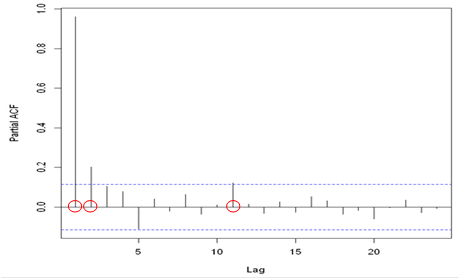

In [4]:
data_Bam= read_excel("DATABamar.xlsx")
data_Bam<-data.frame(data_Bam)
head(data_Bam[,1:length(data_Bam)])

# La primera columna hace referencia a la base de datos totales que sera utilizada 
# para la normzalización, Bamy variable a pronósticar, X1, X2, X11 son las variables de entrada

Bam,Bamy,X1,X2,X11
717,889,883,783,717
867,883,889,883,867
792,883,883,889,792
733,850,883,883,733
750,883,850,883,750
783,883,883,850,783


Con el objetivo de realizar una validación de los datos, estos se dividen en dos conjuntos, el primero es un conjunto de entrenamiento compuesto por el 80% con el que se genera el modelo de los datos, y el segundo es un conjunto de prueba definido por el 20% del total de los datos los cuales son utilizados para validar el modelo generado en la etapa de entrenamiento.

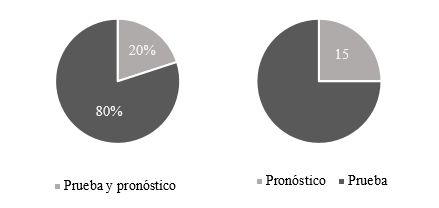

Del total de los datos, se utiliza un 80% para el entrenamiento, un 20% para la prueba de los cuales se obtienen 15 datos con los que se valida el modelo en comparación de los otros. Debido a que la cantidad de datos cambian según el número de rezagos a continuación se presenta el número de datos que son clasificados en entrenamiento y prueba.

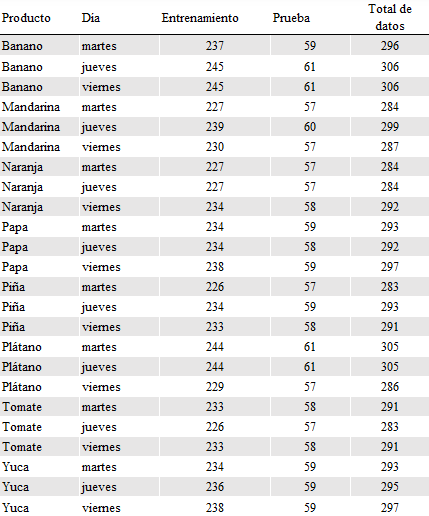

Para el desarrollo de los modelos se deben tener en cuenta los parámetros que se explican a continuación ya que son requeridos por la función.

|Parámetro	                      |Valor
-- | --
|Formula	                      |y = f(número de rezagos significativos)
|Datos	                          |Entrenamiento
|Nodos en la capa oculta	      |N [1-10]
|Tipo de salida	                  |Linear para definir una salida numérica
|Tasa de aprendizaje	          |0.005
|Función de activación	          |Logística Sigmoide
|Numero de repeticiones	          |20 
|Algoritmo de aprendizaje	      |Backpropagation
|Número máximo de pasos	          |100.000

## Modelo RNA

A continuación, se presenta el desarrollo del modelo RNA-Backpropagation para el Banano del dia martes. Los modelos RNA de los demas productos se enuentra en la misma carpeta del presente notebook en un R code denominado "Modelos RNA Apendice.ipynb" y la data obtenida despúes del procesamiento de los modelos se encuentra en la data denominada "Datos Resultados RNA".

In [ ]:
# Inicio del modelo

t <- proc.time() 

# Se independizan las variables para poder trabajar con ellas
attach(data_Bam) # data_Bam es la base de datos que almacena las variables de entrada, salida del producto 
                 # y los datos totales base

# Se seleccionan las variables para la red
bam<- data_Bam[, c(2:5)] # Se seleccionan las últimas 4 columnas que hacen referencia a las 3 variables de entrada
                         # y la variable respuesta

# Datos para la normalización
nbm<- data.frame(Bam[1:292])    # Datos existentes del banano usados para normalizar la serie

# Se escoge el número de datos a procesar en la RED y los de pronostico
Bm<- data.frame(bam[c(1:296),]) # Hace referencia a los últimos 15 datos que se pronóstican a futuro

# Normalizar de cero a uno [0,1] los valores de los datos para poder ingesarlos en la red neuonal y poder trabajar
# con la funcion de activacion sigmoide que posee valores entre (0-1)
bmn<-data.frame(round(((Bm-min(nbm))/(max(nbm)-min(nbm))), 3))

# Se crea dos data.frame el primero con los datos a introducir en la red y el segundo con los datos finales a probar
trainbm<- data.frame(bmn[c(1:237),])           # datos a entrenar en la red
testbm<- data.frame(bmn[c(238:296),])          # datos con los que se prueba la red

# Se independizan las variables para ser utilizadas
attach(bmn)

N_neurona<-1  # Variable que guarda el número de neuronas utilizadas en el bucle

RMSE1<-matrix(0, 10, 3) # Variable que guarda los valores de lo errores RMSE de cada red según el número de neuronas
                        # y el número de variables de entrada
MAPE1<-matrix(0, 10, 3) # Variable que guarda los valores de lo errores MAPE de cada red según el número de neuronas
                        # y el número de variables de entrada


# En los errores RMSE y MAPE la última columna hace referencia a los errores de las 10 neuronas con las totalidad de rezagos
# disminuyendo la cantidad de rezagos a medida que avanza a la izquierda

for(j in 4:2){ # Bucle que varia el número de variables de entradas a utilizar

# Formula dependiente que es utilizada para ingresar en la red neuronal: ubica cada variable y las separa con un "+"
# Ejemplo: Bamy~X1+X2+X11
fmlbm<- as.formula(paste("Bamy ~", paste(names(testbm[2:j]), collapse = " + ")))
  
for (N_neurona in 1:10) { # Bucle que varia el número de neuronas en la capa oculta
    Setpoint_error<-100000000 # Valor generado para guardar los pesos de las neuronas
    nnbm<- neuralnet (threshold=0.01, fmlbm, trainbm[,1:j], hidden = N_neurona, linear.output = TRUE, learningrate = 0.005,
                      act.fct = "logistic", rep = 10, stepmax = 100000) # Red neuronal banano del dia martes
    
    #Bucle pronostico
    
    last_one<- nrow(testbm) # Se determina el numero de filas de la data testbm
    compbm2<- testbm[last_one,1] # Se determina el valor del último dato de la data testbm
    while(is.na(compbm2)){  # Condición que indica que mientras el último dato de la data compbm2 sea NA ejecute la función
      Bamy_r<-(compute(nnbm, within(testbm[,1:j], rm(Bamy)))$net.result) # Función de pronóstico
      
      contbm1<-0 # Contador utilizado en el for
      
      for (i in 1:length(Bamy_r)) { # Bucl que recorre todo el largo de Bamy_r - variable que pronóstico
        compbm<-Bamy_r[i,] # Variable que guarda el valor de Bamy_r según i
        if(is.na(compbm)){} # Condición que indica si compbm es un NA actualice el valor de contbm1 y actualice
                            # los valores de las variables rezagadas por el valor anterior
        else{
          contbm1<-contbm1+1 
        }
      }
      # Actualización de los rezagos por los valores anteriores a estos
      testbm[contbm1+1,2]<- Bamy_r[contbm1]         # Actualización de rezago 1
      testbm[contbm1+1,3]<- testbm[contbm1-1,1]     # Actualización de rezago 2
      testbm[contbm1+1,4]<- testbm[contbm1-10,1]    # Actualización de rezago 11
      testbm[contbm1,1]<-Bamy_r[contbm1]            # Actualización del valor pronósticado
      compbm2<- testbm[last_one,1]                  # Actualización de la variable compbm2
      
    }
    
    pred.bm<- data.frame(round(Bamy_r, 3))*(max(nbm)-min(nbm))+min(nbm) # Variable que guarda los valores del pronóstico
                                                                        # desnormalizados
    
    ##### FIN BUCLE PRONÓSTICO #####
    
      
      # Raiz del error cuadrado medio
      RMSEbm<- sqrt(sum((data.frame(data_Bam$Bam[293:307])- data.frame(pred.bm[45:59, 1]))^2)/nrow(data.frame(data_Bam$Bam[293:307])))
      # Error medio absoluto porcentual
      MAPEbm<- sum(((abs(data.frame(data_Bam$Bam[293:307])- data.frame(pred.bm[45:59, 1])))/data.frame(data_Bam$Bam[293:307]))*100)/nrow(data.frame(data_Bam$Bam[293:307]))
      
      # Guarda los errores en la matriz dependiendo del número de neuronas y de rezagos
      
      RMSE1[N_neurona,j-1]<-RMSEbm # Guardar los pesos RMSE de las neuronas según variable y número de neuronas
      MAPE1[N_neurona,j-1]<-MAPEbm # Guardar los pesos RMSE de las neuronas según variable y número de neuronas
      
    # Se vuelven a generar los datos para cada bucle (bucle de neuronas y número de variables)
    
    bam<- data_Bam[, c(2:5)]
    nbm<- data.frame(Bam[1:292])     
    Bm<- data.frame(bam[c(1:296),])
    bmn<-data.frame(round(((Bm-min(nbm))/(max(nbm)-min(nbm))), 3))
    trainbm<- data.frame(bmn[c(1:237),])        
    testbm<- data.frame(bmn[c(238:296),])       
    attach(bmn)
    

}
}

proc.time()-t  # Tiempo calculado por cada modelo

In [ ]:
write.csv(RMSE1, file="RMSE1rnaBmar.csv") # Los errores RMSE de los modelo se guardan en RMSE1
write.csv(MAPE1, file="MAPE1rnaBmar.csv") # Los errores RMSE de los modelo se guardan en MAPE1

En el modelo anterior la seccion que enuncia la actualización de los rezagos se puede apreciar a continuación. La condición indica que si el valor de Variable a predecir es NA es porque la formula opera las tres variables para obtener la salida, pero si una de esas variables es un NA la variable se predice como NA y esto genera que el modelo actualice nuevamente los valores rezagados y determine en este momento con todas las variables actualizadas el valor de la variable a predecir.

NA en X1

n|Variable a predecir	|  X1	|  X2	| X11
-- | -- | -- | -- | --
5|0.74	                |0.74	|0.74	|0.73
6|0.72	                |0.74	|0.74	|0.73
7|NA	                |NA  	|0.74	|0.73
8|NA	                |NA	    |0.72	|0.69
9|NA	                |NA	    |NA 	|0.76

X1 Actualizado

n|Variable a predecir	|  X1	|  X2	| X11
-- | -- | -- | -- | --
5|0.74	                |0.74	|0.74	|0.73
6|0.72	                |0.74	|0.74	|0.73
7|NA  	                |0.72	|0.74	|0.73
8|NA 	                |NA	    |0.72	|0.69
9|NA	                |NA 	|0.69	|0.76

Variable a predecir puede obtenerse (valor 7 de la variable a predecir actualizado)

n|Variable a predecir	|  X1	|  X2	| X11
-- | -- | -- | -- | --
5|0.74	                |0.74	|0.74	|0.73
6|0.72	                |0.74	|0.74	|0.73
7|0.69	                |0.72	|0.74	|0.73
8|NA	                |NA 	|0.72	|0.69
9|NA	                |NA 	|0.69	|0.76

Se presenta una red neuronal generada por el modelo para el banano del dia martes la cual esta compuesta por tres nodos e la capa de entrada, dos en la capa oculta y una en la capa de salida, con los respectivos pesos por conexión entre nodos.

#### Red Neuronal, Banano-martes(3, 2, 1)

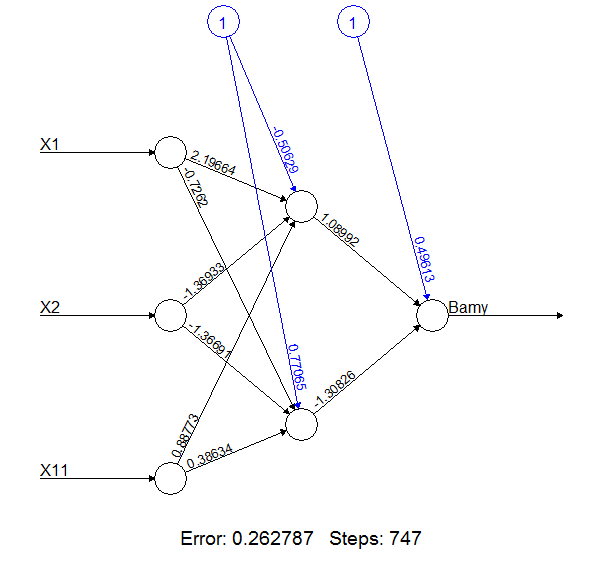

### Referencias Bibliográficas

Damián, J. M. (2001). Redes Neuronales: Conceptos Básicos y Aplicaciones, 55. Retrieved from ftp://decsai.ugr.es/pub/usuarios/castro/Material-Redes-Neuronales/Libros/matich-redesneuronales.pdf

Llano, L., Hoyos, A., Arias, F., & Velásquez, J. (2007). Comparación del Desempeño de Función de Activación en Redes Feedforward para aproximas Funciones de Datos con y sin ruido. Avances En Sistemas E Informática, 4, 10. Retrieved from http://bdigital.unal.edu.co/15163/1/9756-17596-1-PB.pdf

Valencia, M., Yáñez, C., & Sánchez, L. (2006). Algoritmo Backpropagation para Redes Neuronales: conceptos y aplicaicones, 14. Retrieved from http://www.repositoriodigital.ipn.mx/bitstream/123456789/8628/1/Archivo que incluye portada%2C índice y texto.pdf